# KNN REGRESSOR

In [1]:
# basics
import os, sys

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# data viewer
from sscode.data import Loader, load_moana_hindcast_ss
from sscode.pca import PCA_DynamicPred
from sscode.cca import CCA_Analysis
from sscode.linear import MultiLinear_Regression
from sscode.knn import KNN_Regression
from sscode.plotting.utils import plot_ccrs_nz
from sscode.plotting.validation import plot_stats

# warnings
import warnings
warnings.filterwarnings('ignore')


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



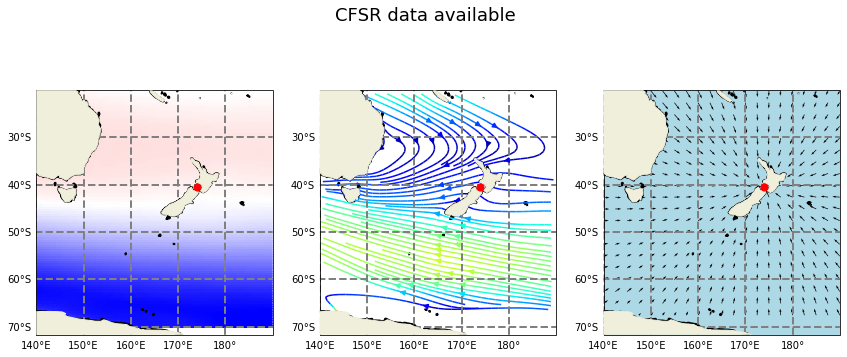

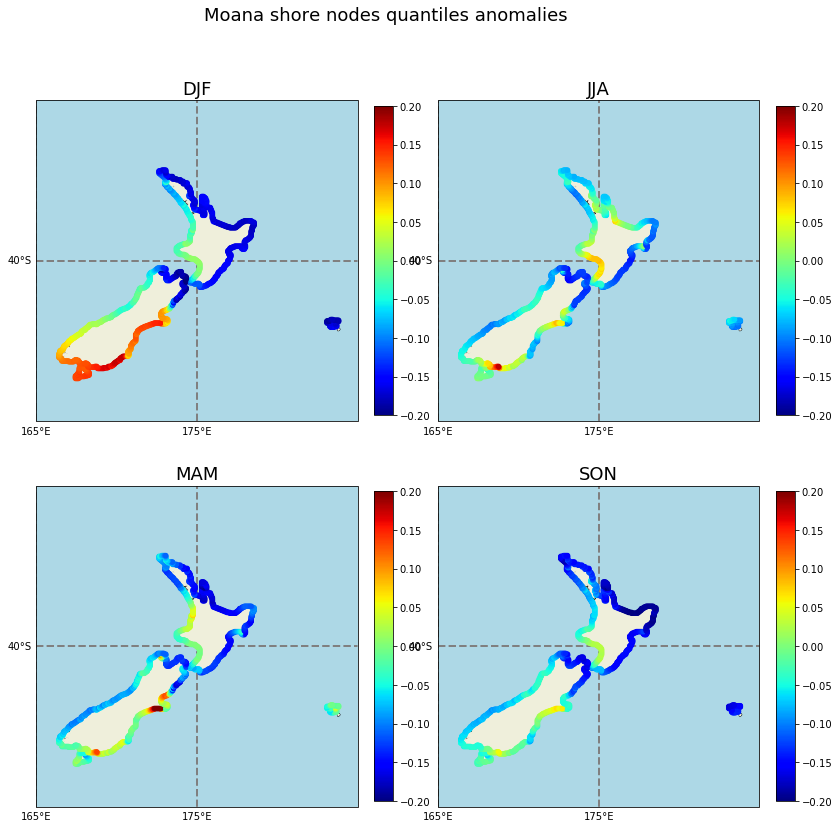

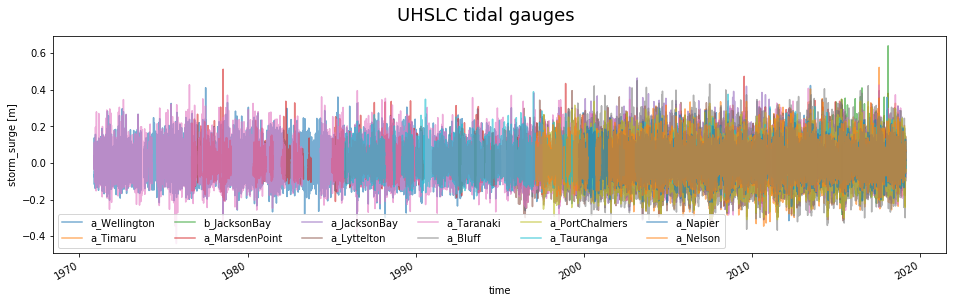

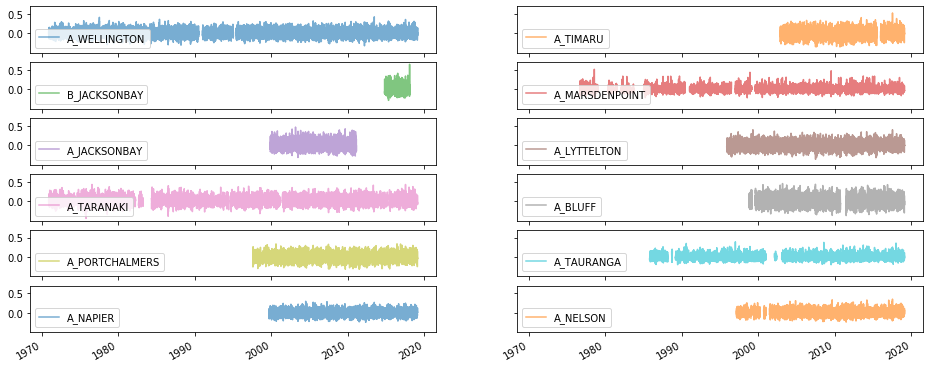

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc']
)

In [3]:
load_cfsr_moana_uhslc.location

(173.9, -40.5)


 plotting 3 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



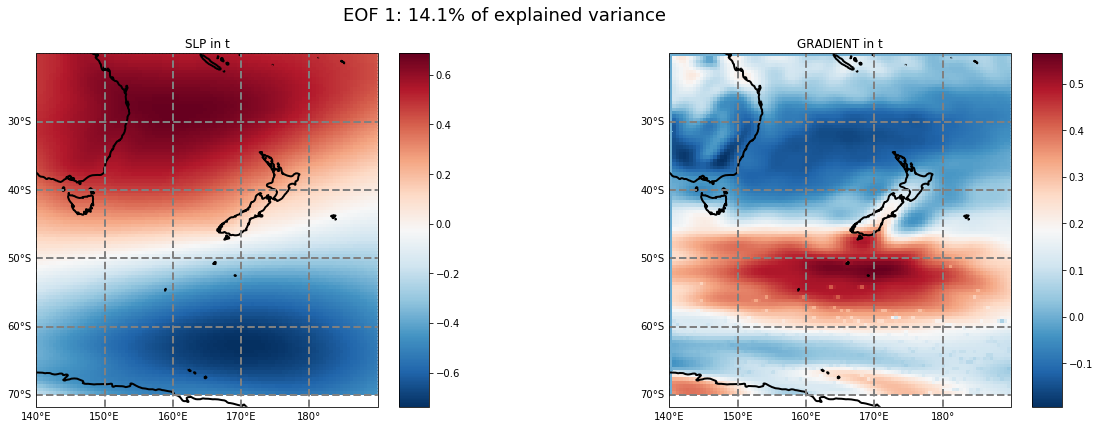

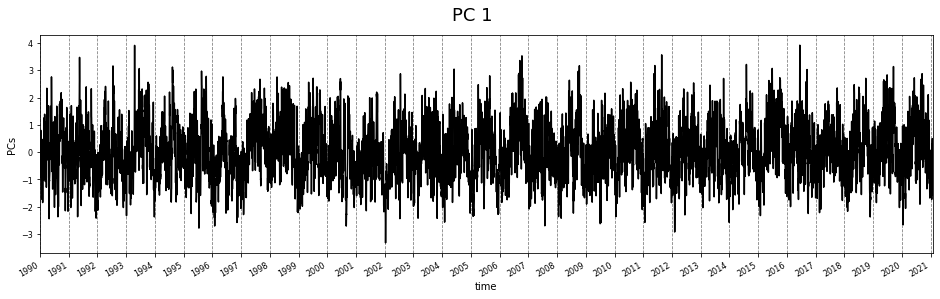

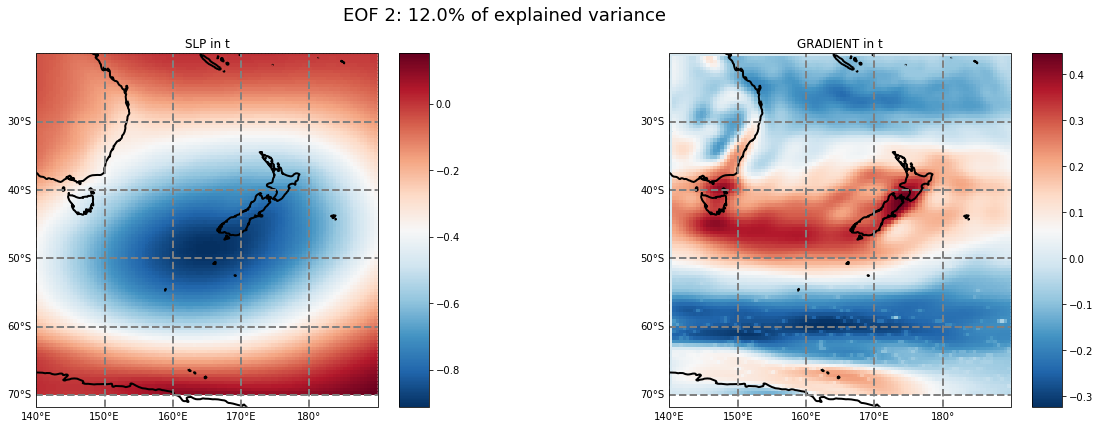

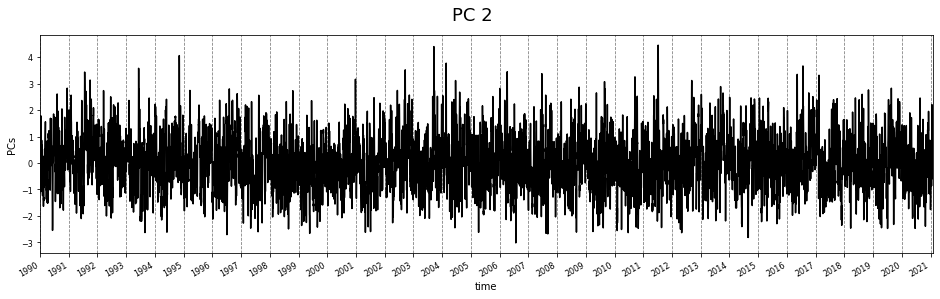

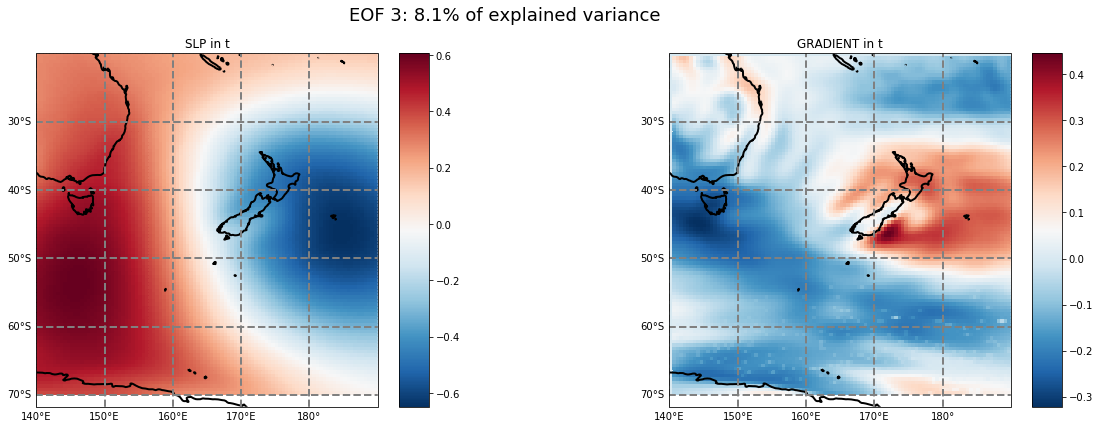

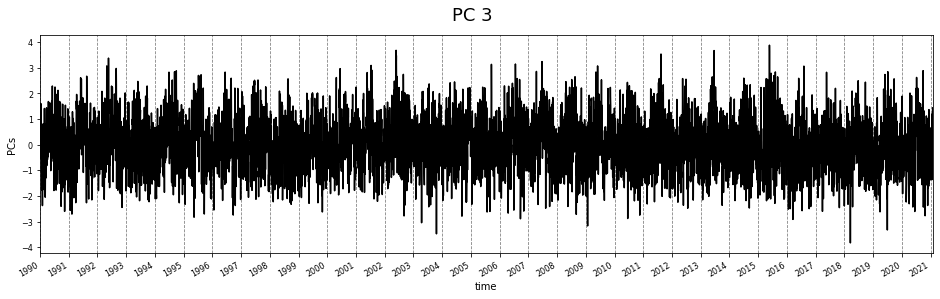

In [4]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    from sscode.plotting.pca import plot_pcs
    plot_pcs(pcs_cfsr,n_plot=3)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp\
            .sel(time=slice('1990','2010')),
        # pres_vars=('wind_proj','lon','lat'),
        calculate_gradient=True,
        winds=(True,load_cfsr_moana_uhslc.predictor_wind),
        region=(True,(
            load_cfsr_moana_uhslc.location[0]-2.1,
            load_cfsr_moana_uhslc.location[0]+2.1,
            load_cfsr_moana_uhslc.location[1]+2.1,
            load_cfsr_moana_uhslc.location[1]-2.1
        )),
        time_lapse=2, # 1 equals to NO time delay 
        time_resample='1D',
        pca_plot=True
    )

## KNN regression with regional predictor

This is a snippet of the model outlook:

```
    # perform the knn regression
    neigh = KNeighborsRegressor() # TODO: add params
    # specify parameters to test
    param_grid = {
        'n_neighbors': np.arange(1,k_neighbors,5)
    }
    # use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(neigh, param_grid, cv=5)
    # fit model to data
    knn_gscv.fit(X_train, y_train)
    prediction = knn_gscv.predict(X_test)
```

where the best number of neighbors is selected, cross-validating the training and testing sizes!!

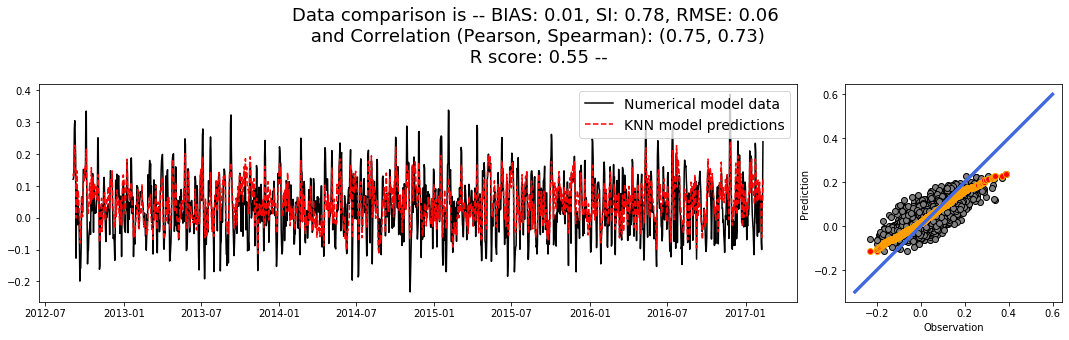

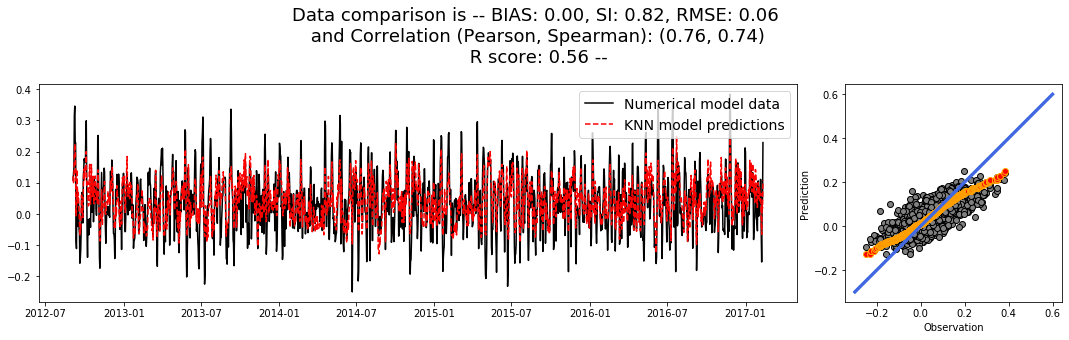

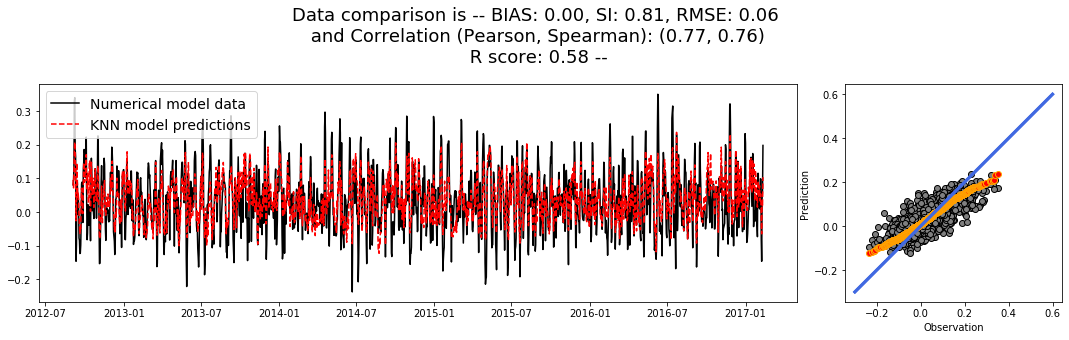

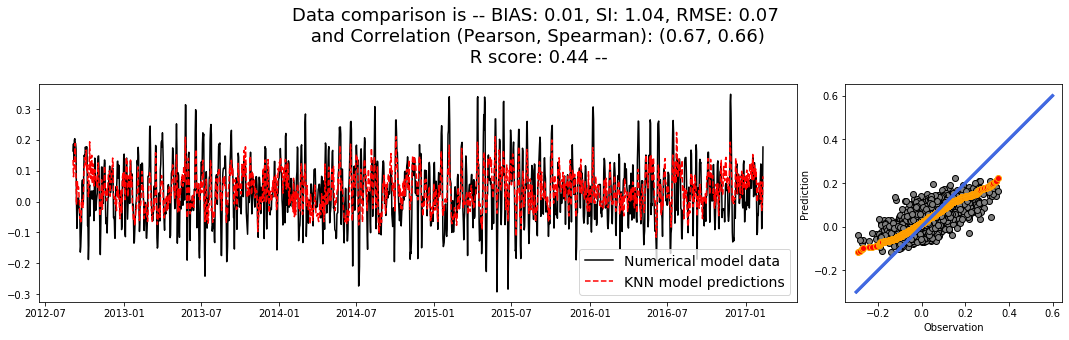

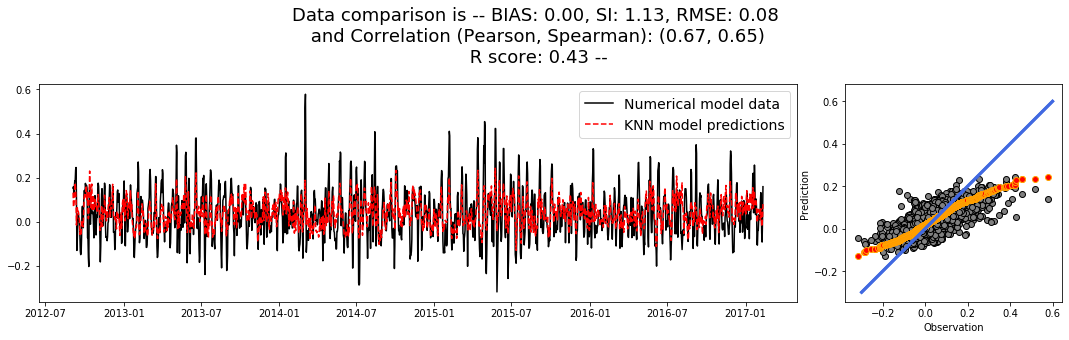

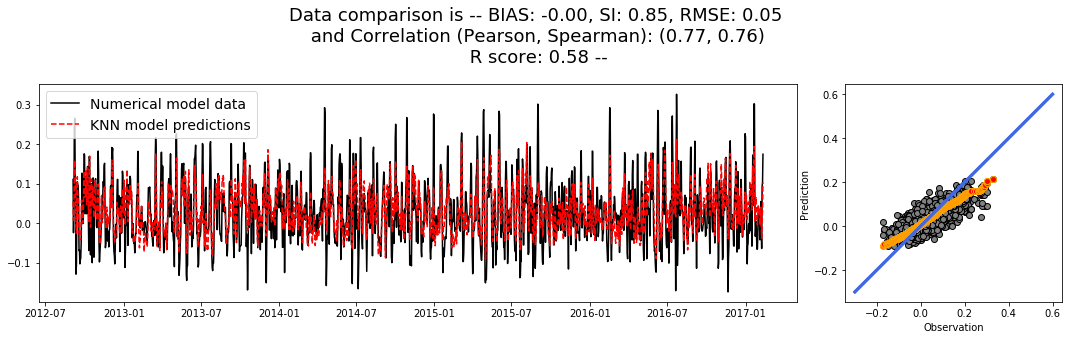

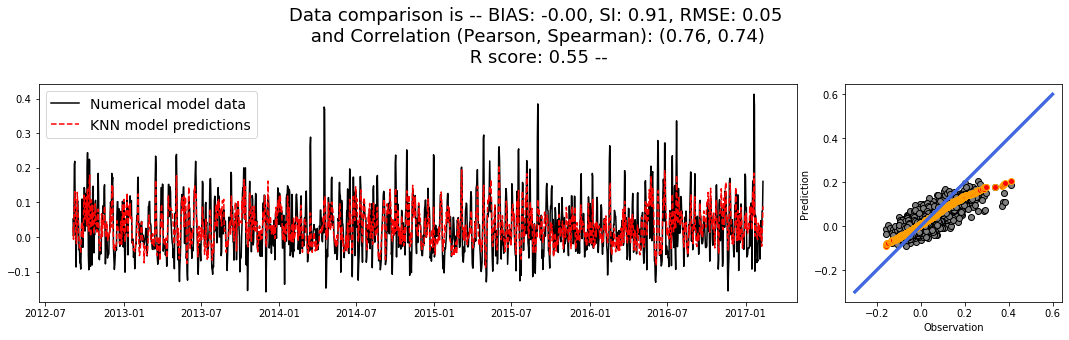

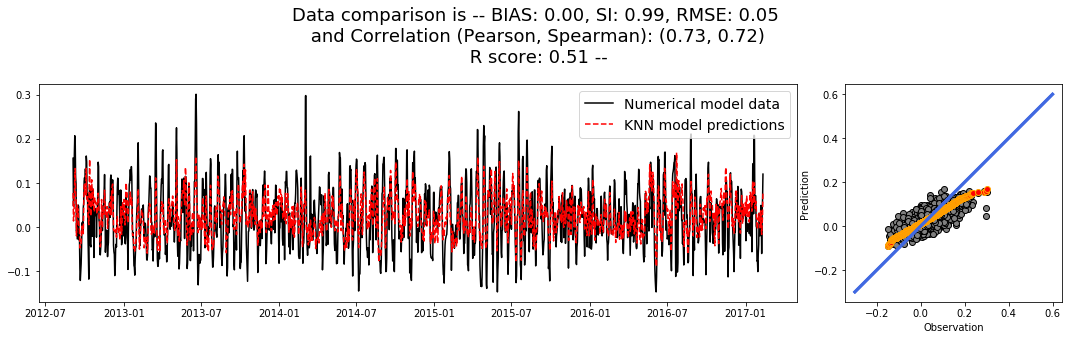

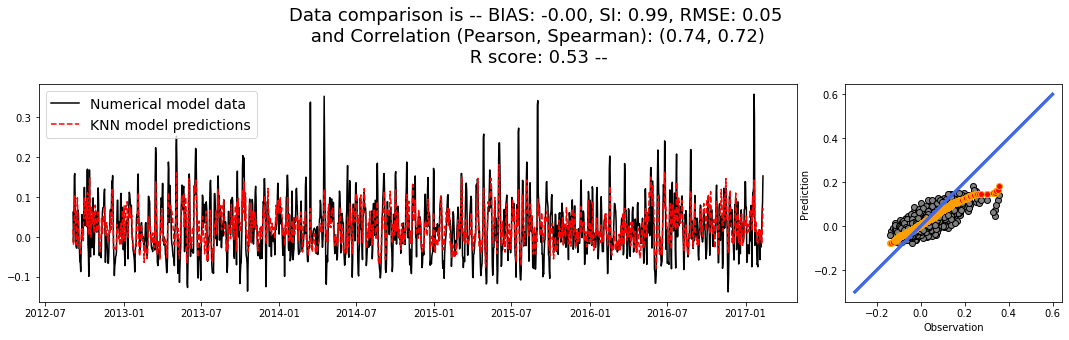

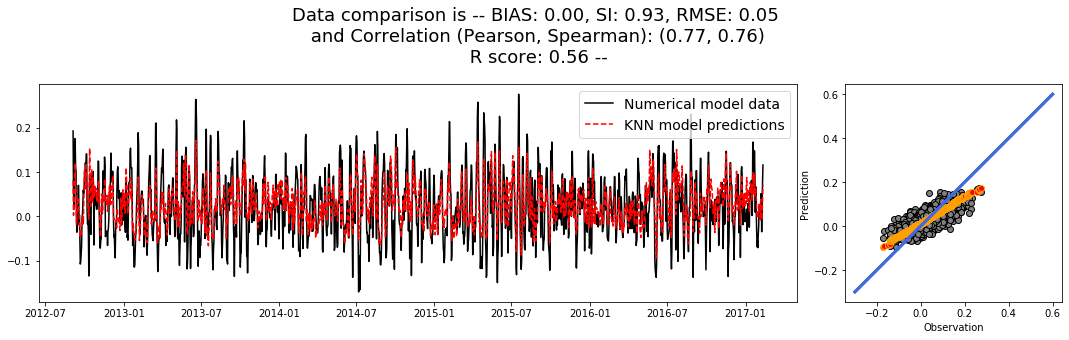

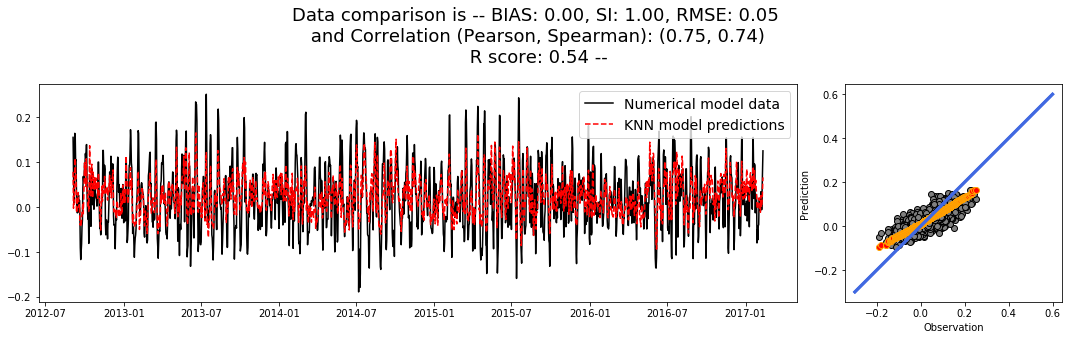

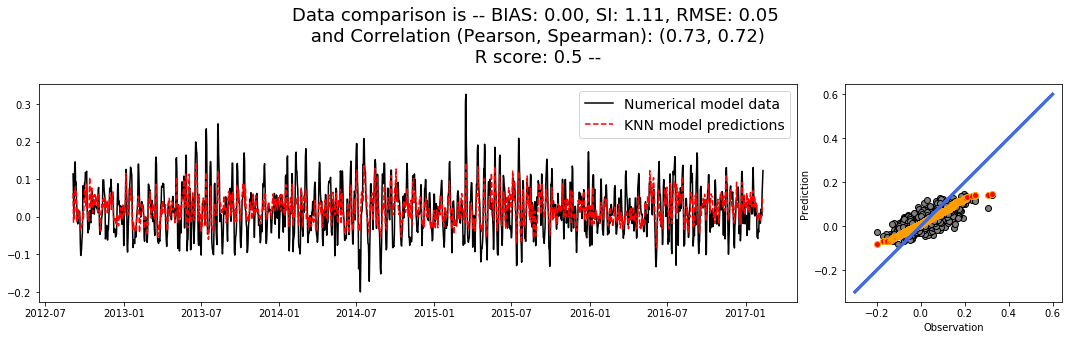

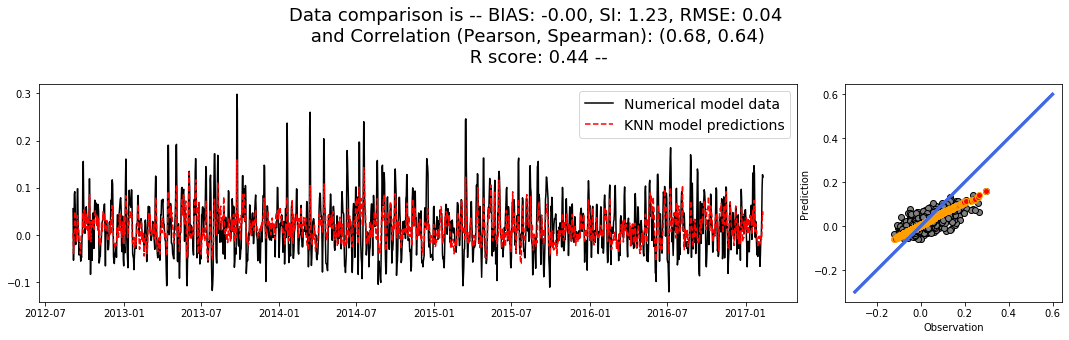

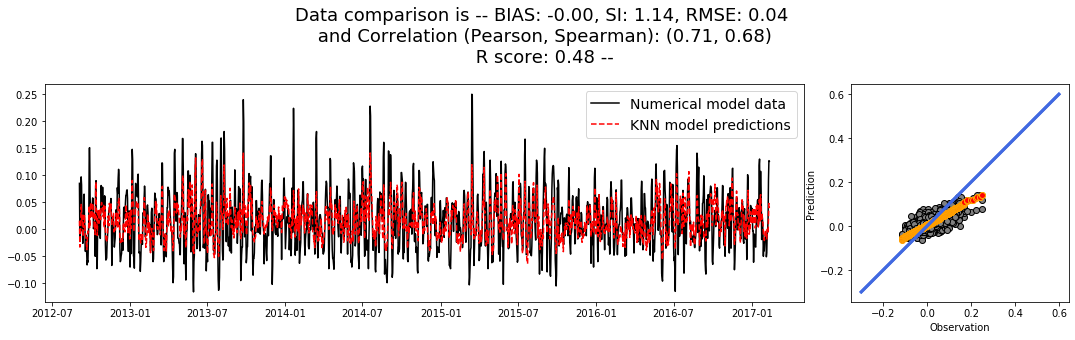

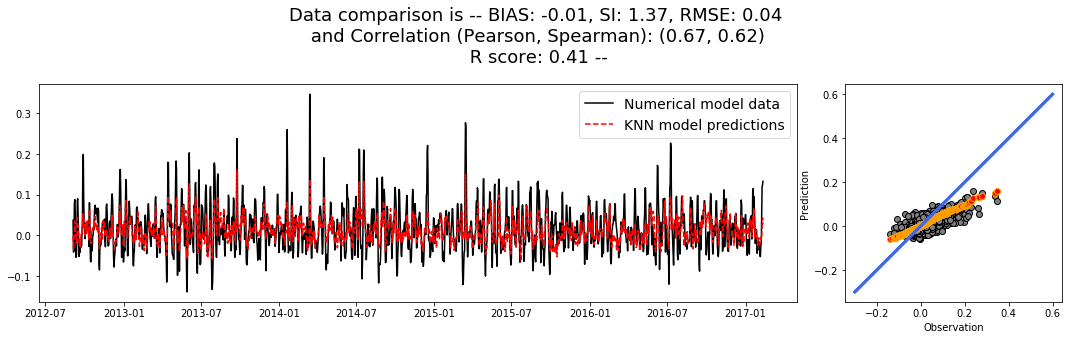

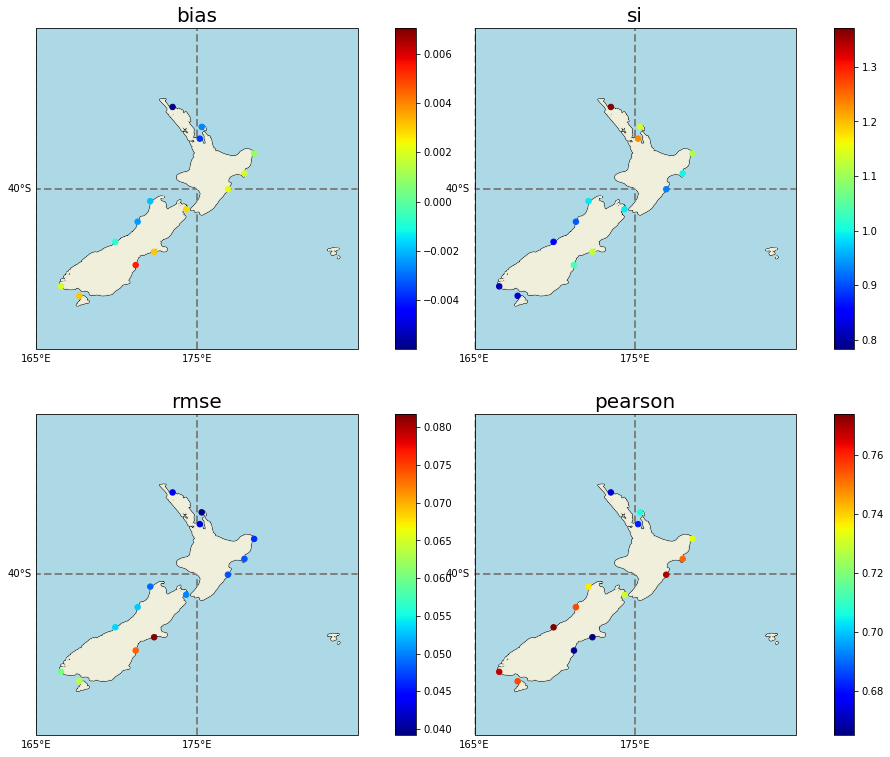

In [5]:
# perform the Multilinear-Regression
stats = []
sites = np.arange(
    0,len(load_cfsr_moana_uhslc.predictand.site.values),100
)
for stat in sites:
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat = KNN_Regression(
        pcs_cfsr, ss_moana
    )
    stats.append(stats_stat)
# plot stats
plot_stats(load_cfsr_moana_uhslc.predictand.isel(site=sites).lon.values,
           load_cfsr_moana_uhslc.predictand.isel(site=sites).lat.values,
           np.array(stats))